RDD and Operations

In [0]:
# read text files into RDD
course_rdd = sc.textFile('dbfs:/FileStore/lab5/courses.txt')
student_rdd = sc.textFile('dbfs:/FileStore/lab5/students.txt')
 
# create pair RDD
course_pair_rdd = course_rdd.map(lambda x: x.split(',')).map(lambda x: (x[0],x[2]+' by '+x[1]))
student_pair_rdd = student_rdd.map(lambda x: x.split(',')).map(lambda x: (x[0],x[1]))
 
# join by key
joined = student_pair_rdd.join(course_pair_rdd).map(lambda x: (x[1][0],x[1][1])).groupByKey().sortByKey(ascending=True)
 
# print out all courses each user takes
for (username,courses) in joined.collect():
  print('user:',username)
  for course in courses:
    print('\t',course)

user: alice
 758b by mis
 808x by mis
user: bob
 135m by math
user: charlie
 201 by cs
 303 by cs
 404 by cs
user: david
 404d by mkt
 413 by fin

DataFrame, Table

In [0]:
wine = spark.read.format("csv").option("header", "true").option("delimiter",";").load("dbfs:/FileStore/lab5/winequality_red.csv")
wine.registerTempTable("wine_table")

In [0]:

from pyspark import SparkConf, SparkContext, SQLContext
 
#sc = SparkContext()
sqlContext = SQLContext(sc)
 
rows = sqlContext.sql("select * from wine_table")
i = 0
for row in rows.rdd.collect():
  print(row.chlorides,',',row.pH)
  #print(row.fixed_acidity,',',row.quality,':',row.is_red)
  i += 1
  if i == 10:
    break

0.076 , 3.51
0.098 , 3.2
0.092 , 3.26
0.075 , 3.16
0.076 , 3.51
0.075 , 3.51
0.069 , 3.3
0.065 , 3.39
0.073 , 3.36
0.071 , 3.35

Machine learning - Random Forest

In [0]:
import pandas as pd
  
red_wine = spark.read.format("csv").option("header", "true").option("delimiter",";").load("dbfs:/FileStore/lab5/winequality_red.csv").toPandas()
white_wine = spark.read.format("csv").option("delimiter",";").option("header", "true").load("dbfs:/FileStore/lab5/winequality_white.csv").toPandas()
 
red_wine['is_red'] = 1
white_wine['is_red'] = 0
 
data = pd.concat([red_wine, white_wine], axis=0)
 
# Remove spaces from column names
data.rename(columns=lambda x: x.replace(' ', '_'), inplace=True)
 
data.head()

Out[23]:

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,is_red
0,7.4,0.7,0,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5,1
1,7.8,0.88,0,2.6,0.098,25,67,0.9968,3.2,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15,54,0.997,3.26,0.65,9.8,5,1
3,11.2,0.28,0.56,1.9,0.075,17,60,0.998,3.16,0.58,9.8,6,1
4,7.4,0.7,0,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5,1


Out[24]:

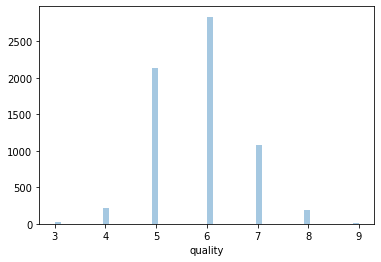

<matplotlib.axes._subplots.AxesSubplot at 0x7f0edfcae890>

In [0]:
import seaborn as sns
sns.distplot(data['quality'], kde=False)

In [0]:
import numpy as np
 
high_quality = (data['quality'].astype(int) >= 7).astype(int)
data.quality = high_quality

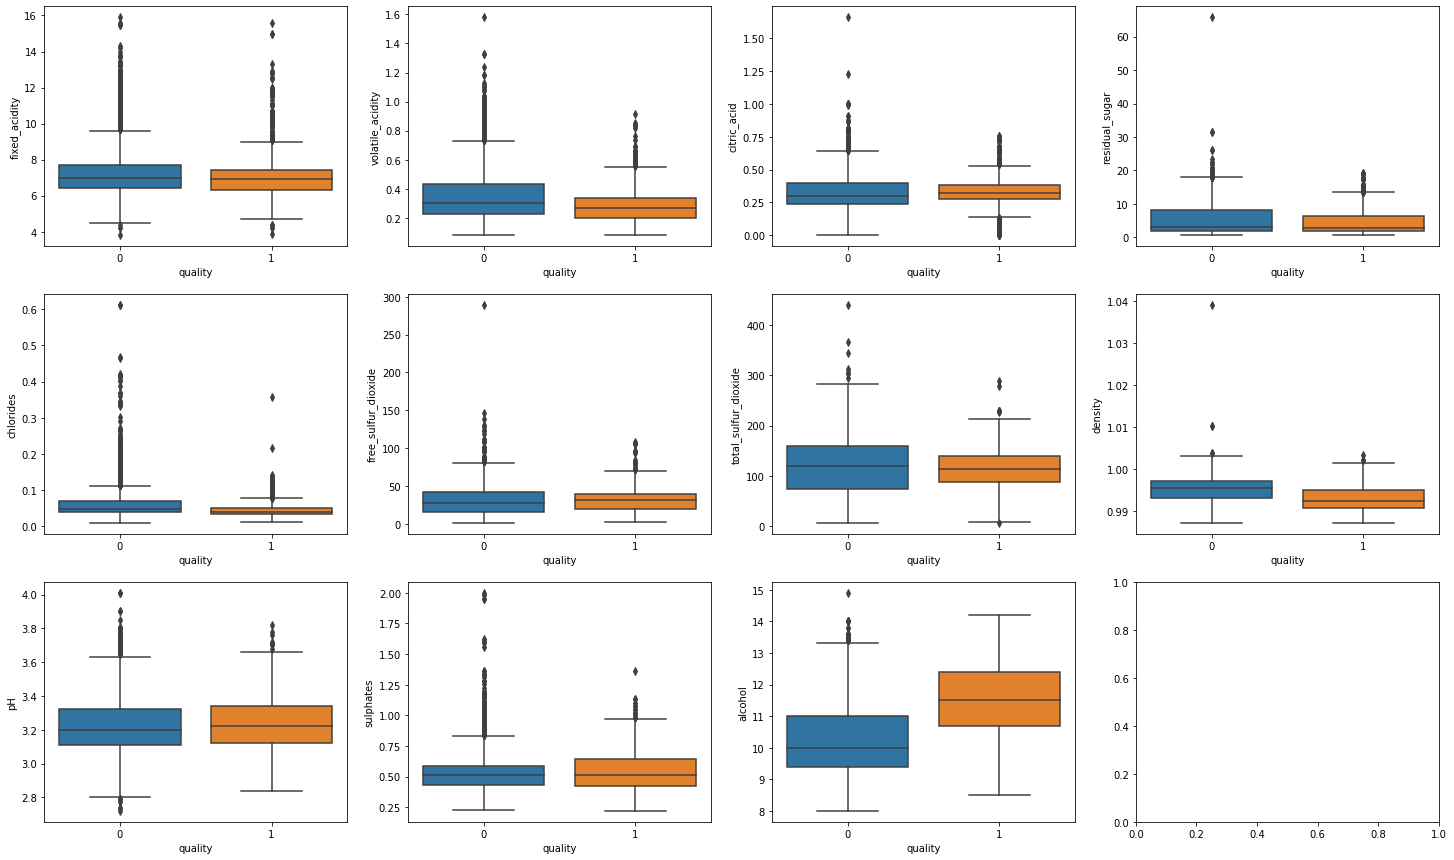

In [0]:
import matplotlib.pyplot as plt
 
dims = (3, 4)
 
f, axes = plt.subplots(dims[0], dims[1], figsize=(25, 15))
axis_i, axis_j = 0, 0
for col in data.columns:
  if col == 'is_red' or col == 'quality':
    continue # Box plots cannot be used on indicator variables
  sns.boxplot(x = high_quality, y = data[col].astype(float), ax=axes[axis_i, axis_j])
  axis_j += 1
  if axis_j == dims[1]:
    axis_i += 1
    axis_j = 0

In [0]:
data.isna().any()

Out[27]: fixed_acidity False
volatile_acidity False
citric_acid False
residual_sugar False
chlorides False
free_sulfur_dioxide False
total_sulfur_dioxide False
density False
pH False
sulphates False
alcohol False
quality False
is_red False
dtype: bool

In [0]:
from sklearn.model_selection import train_test_split
 
train, test = train_test_split(data, random_state=123)
X_train = train.drop(["quality"], axis=1)
X_test = test.drop(["quality"], axis=1)
y_train = train.quality
y_test = test.quality

In [0]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
 
# The predict method of sklearn's RandomForestClassifier returns a binary classification (0 or 1). 
n_estimators = 10
model = RandomForestClassifier(n_estimators=n_estimators, random_state=np.random.RandomState(123))
model.fit(X_train, y_train)
 
# predict_proba returns [prob_negative, prob_positive], so slice the output with [:, 1]
predictions_test = model.predict_proba(X_test)[:,1]
auc_score = roc_auc_score(y_test, predictions_test)
print(auc_score)

0.888902759745664

In [0]:

feature_importances = pd.DataFrame(model.feature_importances_, index=X_train.columns.tolist(), columns=['importance'])
feature_importances.sort_values('importance', ascending=False)

Out[30]:

,importance
alcohol,0.162047
density,0.115506
volatile_acidity,0.089138
chlorides,0.082570
pH,0.081632
citric_acid,0.081109
total_sulfur_dioxide,0.081001
sulphates,0.078901
residual_sugar,0.077866
free_sulfur_dioxide,0.076833


Deep Learning - Digit recognition using CNN

In [0]:
import os
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
 
dbutils.widgets.removeAll()
dbutils.widgets.dropdown('USE_GPU', 'no', ['no', 'yes'])
USE_GPU = dbutils.widgets.get('USE_GPU') == 'no'

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
from collections import namedtuple
 
MNIST_DIR = '/tmp/data/mnist'
use_cuda = USE_GPU and torch.cuda.is_available()
 
Params = namedtuple('Params', ['batch_size', 'test_batch_size', 'epochs', 'lr', 'momentum', 'seed', 'cuda', 'log_interval'])
args = Params(batch_size=64, test_batch_size=1000, epochs=5, lr=0.01, momentum=0.5, seed=1, cuda=use_cuda, log_interval=200)

In [0]:
torch.manual_seed(args.seed)
 
data_transform_fn = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))])
 
train_loader = torch.utils.data.DataLoader(
        datasets.MNIST(MNIST_DIR, train=True, download=True,
                       transform=data_transform_fn),
        batch_size=args.batch_size, shuffle=True, num_workers=1)
 
test_loader = torch.utils.data.DataLoader(
        datasets.MNIST(MNIST_DIR, train=False, 
                       transform=data_transform_fn),
        batch_size=args.test_batch_size, shuffle=True, num_workers=1)

Downloading http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz to /tmp/data/mnist/MNIST/raw/train-images-idx3-ubyte.gz
0.0%0.1%0.2%0.2%0.3%0.4%0.5%0.6%0.7%0.7%0.8%0.9%1.0%1.1%1.2%1.2%1.3%1.4%1.5%1.6%1.7%1.7%1.8%1.9%2.0%2.1%2.1%2.2%2.3%2.4%2.5%2.6%2.6%2.7%2.8%2.9%3.0%3.1%3.1%3.2%3.3%3.4%3.5%3.6%3.6%3.7%3.8%3.9%4.0%4.0%4.1%4.2%4.3%4.4%4.5%4.5%4.6%4.7%4.8%4.9%5.0%5.0%5.1%5.2%5.3%5.4%5.5%5.5%5.6%5.7%5.8%5.9%6.0%6.0%6.1%6.2%6.3%6.4%6.4%6.5%6.6%6.7%6.8%6.9%6.9%7.0%7.1%7.2%7.3%7.4%7.4%7.5%7.6%7.7%7.8%7.9%7.9%8.0%8.1%8.2%8.3%8.3%8.4%8.5%8.6%8.7%8.8%8.8%8.9%9.0%9.1%9.2%9.3%9.3%9.4%9.5%9.6%9.7%9.8%9.8%9.9%10.0%10.1%10.2%10.2%10.3%10.4%10.5%10.6%10.7%10.7%10.8%10.9%11.0%11.1%11.2%11.2%11.3%11.4%11.5%11.6%11.7%11.7%11.8%11.9%12.0%12.1%12.1%12.2%12.3%12.4%12.5%12.6%12.6%12.7%12.8%12.9%13.0%13.1%13.1%13.2%13.3%13.4%13.5%13.6%13.6%13.7%13.8%13.9%14.0%14.0%14.1%14.2%14.3%14.4%14.5%14.5%14.6%14.7%14.8%14.9%15.0%15.0%15.1%15.2%15.3%15.4%15.5%15.5%15.6%15.7%15.8%15.9%16.0%16.0%16.1%16.2%16.3%16.4%16.4%16.5%16.6%16.7%16.8%16.9%16.9%17.0%17.1%17.2%17.3%17.4%17.4%17.5%17.6%17.7%17.8%17.9%17.9%18.0%18.1%18.2%18.3%18.3%18.4%18.5%18.6%18.7%18.8%18.8%18.9%19.0%19.1%19.2%19.3%19.3%19.4%19.5%19.6%19.7%19.8%19.8%19.9%20.0%20.1%20.2%20.2%20.3%20.4%20.5%20.6%20.7%20.7%20.8%20.9%21.0%21.1%21.2%21.2%21.3%21.4%21.5%21.6%21.7%21.7%21.8%21.9%22.0%22.1%22.1%22.2%22.3%22.4%22.5%22.6%22.6%22.7%22.8%22.9%23.0%23.1%23.1%23.2%23.3%23.4%23.5%23.6%23.6%23.7%23.8%23.9%24.0%24.0%24.1%24.2%24.3%24.4%24.5%24.5%24.6%24.7%24.8%24.9%25.0%25.0%25.1%25.2%25.3%25.4%25.5%25.5%25.6%25.7%25.8%25.9%26.0%26.0%26.1%26.2%26.3%26.4%26.4%26.5%26.6%26.7%26.8%26.9%26.9%27.0%27.1%27.2%27.3%27.4%27.4%27.5%27.6%27.7%27.8%27.9%27.9%28.0%28.1%28.2%28.3%28.3%28.4%28.5%28.6%28.7%28.8%28.8%28.9%29.0%29.1%29.2%29.3%29.3%29.4%29.5%29.6%29.7%29.8%29.8%29.9%30.0%30.1%30.2%30.2%30.3%30.4%30.5%30.6%30.7%30.7%30.8%30.9%31.0%31.1%31.2%31.2%31.3%31.4%31.5%31.6%31.7%31.7%31.8%31.9%32.0%32.1%32.1%32.2%32.3%32.4%32.5%32.6%32.6%32.7%32.8%32.9%33.0%33.1%33.1%33.2%33.3%33.4%33.5%33.6%33.6%33.7%33.8%33.9%34.0%34.0%34.1%34.2%34.3%34.4%34.5%34.5%34.6%34.7%34.8%34.9%35.0%35.0%35.1%35.2%35.3%35.4%35.5%35.5%35.6%35.7%35.8%35.9%36.0%36.0%36.1%36.2%36.3%36.4%36.4%36.5%36.6%36.7%36.8%36.9%36.9%37.0%37.1%37.2%37.3%37.4%37.4%37.5%37.6%37.7%37.8%37.9%37.9%38.0%38.1%38.2%38.3%38.3%38.4%38.5%38.6%38.7%38.8%38.8%38.9%39.0%39.1%39.2%39.3%39.3%39.4%39.5%39.6%39.7%39.8%39.8%39.9%40.0%40.1%40.2%40.2%40.3%40.4%40.5%40.6%40.7%40.7%40.8%40.9%41.0%41.1%41.2%41.2%41.3%41.4%41.5%41.6%41.7%41.7%41.8%41.9%42.0%42.1%42.1%42.2%42.3%42.4%42.5%42.6%42.6%42.7%42.8%42.9%43.0%43.1%43.1%43.2%43.3%43.4%43.5%43.6%43.6%43.7%43.8%43.9%44.0%44.0%44.1%44.2%44.3%44.4%44.5%44.5%44.6%44.7%44.8%44.9%45.0%45.0%45.1%45.2%45.3%45.4%45.5%45.5%45.6%45.7%45.8%45.9%45.9%46.0%46.1%46.2%46.3%46.4%46.4%46.5%46.6%46.7%46.8%46.9%46.9%47.0%47.1%47.2%47.3%47.4%47.4%47.5%47.6%47.7%47.8%47.9%47.9%48.0%48.1%48.2%48.3%48.3%48.4%48.5%48.6%48.7%48.8%48.8%48.9%49.0%49.1%49.2%49.3%49.3%49.4%49.5%49.6%49.7%49.8%49.8%49.9%50.0%50.1%50.2%50.2%50.3%50.4%50.5%50.6%50.7%50.7%50.8%50.9%51.0%51.1%51.2%51.2%51.3%51.4%51.5%51.6%51.7%51.7%51.8%51.9%52.0%52.1%52.1%52.2%52.3%52.4%52.5%52.6%52.6%52.7%52.8%52.9%53.0%53.1%53.1%53.2%53.3%53.4%53.5%53.6%53.6%53.7%53.8%53.9%54.0%54.0%54.1%54.2%54.3%54.4%54.5%54.5%54.6%54.7%54.8%54.9%55

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
 
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)
      
model = Net()
model.share_memory() 

Out[36]: Net(
 (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
 (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
 (conv2_drop): Dropout2d(p=0.5, inplace=False)
 (fc1): Linear(in_features=320, out_features=50, bias=True)
 (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [0]:
def train_epoch(epoch, args, model, data_loader, optimizer):
    model.train()
    for batch_idx, (data, target) in enumerate(data_loader):
        if args.cuda:
            data, target = data.cuda(), target.cuda()      
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(data_loader.dataset),
                100. * batch_idx / len(data_loader), loss.data.item()))

In [0]:
def test_epoch(model, data_loader):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in data_loader:
        if args.cuda:
            data, target = data.cuda(), target.cuda()      
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.nll_loss(output, target, size_average=False).data.item() # sum up batch loss
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()
 
    test_loss /= len(data_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(data_loader.dataset),
        100. * correct / len(data_loader.dataset)))
 
# Run the training loop over the epochs (evaluate after each)
if args.cuda:
    model = model.cuda()
optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
for epoch in range(1, args.epochs + 1):
    train_epoch(epoch, args, model, train_loader, optimizer)
    test_epoch(model, test_loader)

/local_disk0/tmp/1607805027615-0/PythonShell.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
 import matplotlib as mpl
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.332586
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.336145
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.672064
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.711025
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.798054
/local_disk0/tmp/1607805027615-0/PythonShell.py:8: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
 
/databricks/python/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
 warnings.warn(warning.format(ret))

Test set: Average loss: 0.2056, Accuracy: 9400/10000 (94%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.460992
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.390606
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.602390
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.412870
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.215603

Test set: Average loss: 0.1334, Accuracy: 9590/10000 (96%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.392161
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.413285
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.260655
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.254605
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.370178

Test set: Average loss: 0.1039, Accuracy: 9681/10000 (97%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.269341
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.725416
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.124470
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.388055
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.210628

Test set: Average loss: 0.0910, Accuracy: 9718/10000 (97%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.110640
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.221036
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.294512
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.576743
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.251759

Test set: Average loss: 0.0762, Accuracy: 9766/10000 (98%)